In [82]:
from datasets.load import load_samples, load_n_samples
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from sklearn.feature_extraction.image import extract_patches_2d

%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

debug = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Haar Classifier Training

In [13]:
# Load n training samples

n = 62

training_samples = load_n_samples('train', 'datasets', n)

if debug: print(str(training_samples[0]))

## Play Around With Some Descriptive Statistics of the Training Data

waldo's' max_y is 6647.
There corresponding image looks like this:


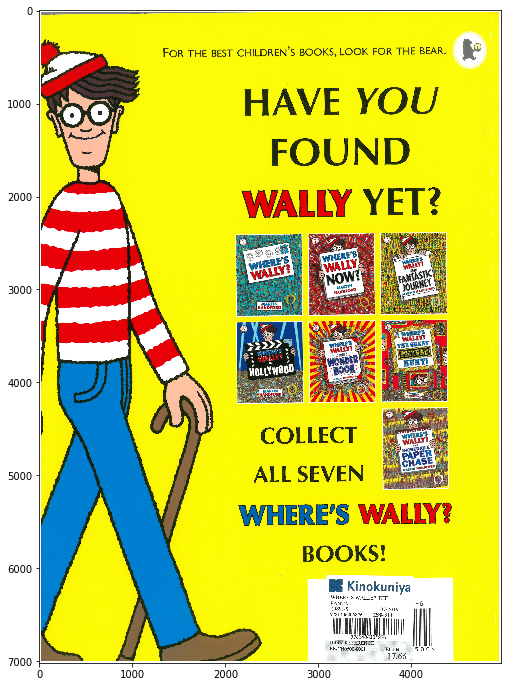

waldo's' max_x is 2377.
There corresponding image looks like this:


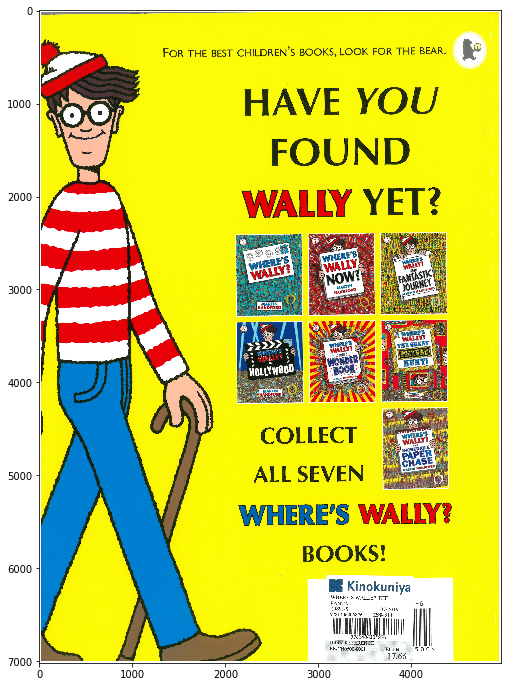

wenda's' max_y is 1954.
There corresponding image looks like this:


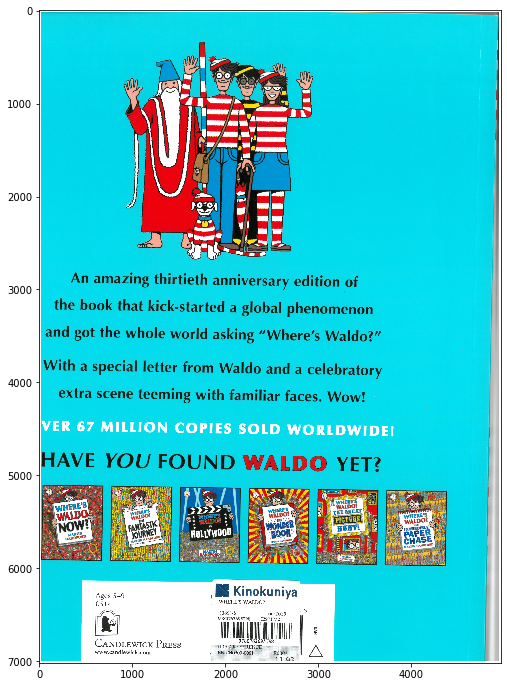

wenda's' max_x is 708.
There corresponding image looks like this:


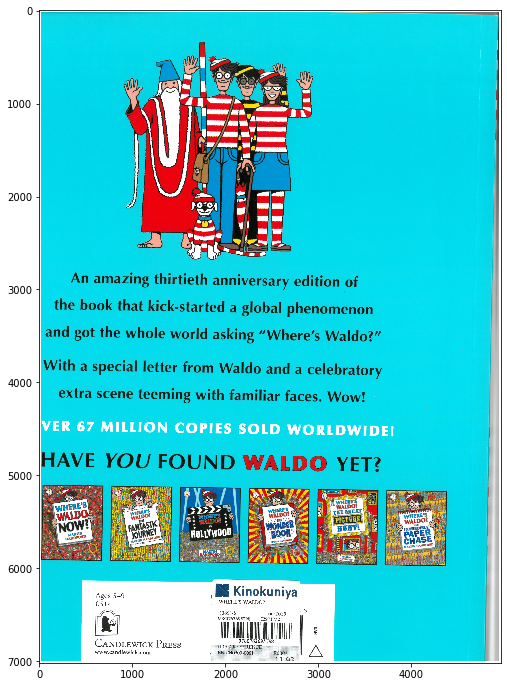

wizard's' max_y is 2038.
There corresponding image looks like this:


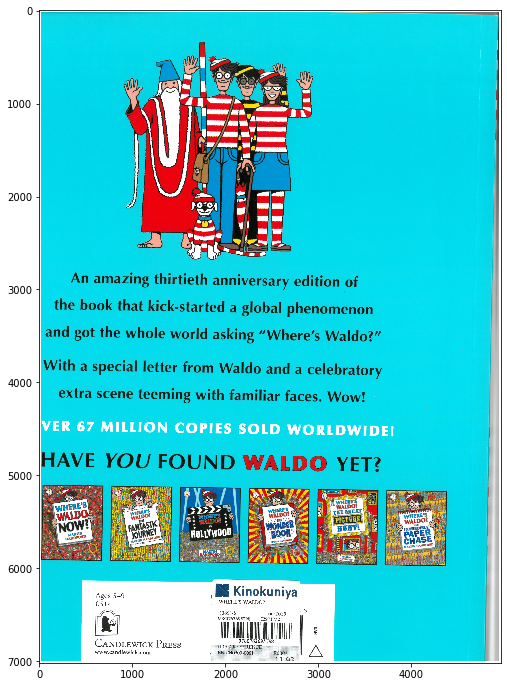

wizard's' max_x is 884.
There corresponding image looks like this:


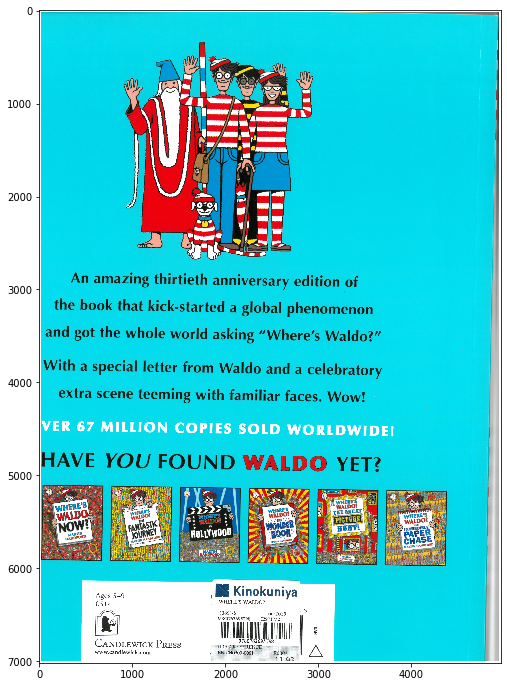

In [56]:
from copy import deepcopy

# Find the largest dimensions of annotated bounding boxes

dimensions = {'waldo':[], 'wenda':[], 'wizard':[]}
tmp_0 = {'dim': 0, 'img_original': [], 'img_boxed': []}
tmp_1 = {'max_y': deepcopy(tmp_0), 'max_x': deepcopy(tmp_0)}
dim_max = {'waldo': deepcopy(tmp_1), 'wenda': deepcopy(tmp_1), 'wizard': deepcopy(tmp_1)}

for sample in training_samples:
    for cl in sample['classes']:
        for box in cl['bounds']:
            try:
                name = cl['name']
                ymin, ymax, xmin, xmax = box[1], box[3], box[0], box[2]
                dim_y, dim_x = ymax - ymin, xmax - xmin
                dimensions[name].append(dict(
                    img_original = sample['img'],
                    img_boxed = sample['img'][ymin:ymax, xmin:xmax],
                    dim = [dim_y, dim_x]))
                # also check if dimensions of bounding boxes significantly differ between classes
                if dim_y > dim_max[name]['max_y']['dim']:
                    dim_max[name]['max_y']['dim'] = dim_y
                    dim_max[name]['max_y']['img_original'] = sample['img']
                    dim_max[name]['max_y']['img_boxed'] = sample['img'][ymin:ymax, xmin:xmax]
                if dim_x > dim_max[name]['max_x']['dim']:
                    dim_max[name]['max_x']['dim'] = dim_x
                    dim_max[name]['max_x']['img_original'] = sample['img']
                    dim_max[name]['max_x']['img_boxed'] = sample['img'][ymin:ymax, xmin:xmax]           
            except Exception as e:
                print("exception: {}".format(e))
                
for name, dims in dim_max.items():
    for dim, values in dims.items():
        print("{}'s' {} is {}.".format(name, dim, values['dim']))
        print("There corresponding image looks like this:")
        fig, ax = plt.subplots(1)
        plt.imshow(values['img_original'])
        plt.show()

## Generate Positive Training Samples

In [4]:
import math

def generate_pos_samples(samples, blowup=1):
    res = []
    for sample in samples:
        for cl in sample['classes']:
            for box in cl['bounds']:
                scales = np.random.uniform(low=1, high=10, size=(blowup,))
                for s in scales:
                    try:
                        ymin, ymax = box[1], box[3]
                        xmin, xmax = box[0], box[2]
                        sx = math.ceil((ymax - ymin)*s/2)
                        sy = math.ceil((xmax - xmin)*s/2)
                        ymin, ymax = ymin - sy, ymax + sy
                        xmin, xmax = xmin - sy, xmax + sy
                        
                        img = sample['img'][ymin:ymax, xmin:xmax]
                        if img.size != 0:
                            #print(img)
                            res.append(dict(
                                name = cl['name'],
                                img = img,
                                scale = 1/s,
                                bbox = [box[0] - xmin,
                                        box[1] - ymin,
                                        box[2] - xmin,
                                        box[3] - ymin]                             
                            ))
                    except Exception as e:
                        print(e)
    np.random.shuffle(res)
    return res

pos_training_samples = generate_pos_samples(training_samples, 2)

## Generate Negative Training Samples

In [85]:
# taken from stackoverflow.com/questions/29663764
def contains_template(img, template):
    img = np.atleast_3d(img)
    tpl = np.atleast_3d(tpl)
    H, W, D = img.shape[:3]
    h, w = template.shape[:2]

    # Integral image and template sum per channel
    sat = img.cumsum(1).cumsum(0)
    tplsum = np.array([template[:, :, i].sum() for i in range(D)])

    # Calculate lookup table for all the possible windows
    iA, iB, iC, iD = sat[:-h, :-w], sat[:-h, w:], sat[h:, :-w], sat[h:, w:] 
    lookup = iD - iB - iC + iA
    # Possible matches
    possible_match = np.where(np.logical_and.reduce([lookup[..., i] == tplsum[i] for i in range(D)]))

    # Find exact match
    for y, x in zip(*possible_match):
        if np.all(img[y+1:y+h+1, x+1:x+w+1] == template):
            #return (y+1, x+1)
            return True
    
    return False


def generate_neg_samples(samples, depth=1):
    res = {'waldo': [], 'wenda': [], 'wizard': []}
    
    for sample in samples:
        img = sample['img']
        
        patches_sample = []
        
        for i in range(1, depth+1):
            n_patches = i**2
            w_patch = img.shape[0] // i - 1
            h_patch = img.shape[1] // i - 1
            window_shape = (w_patch, h_patch)  # TODO: Find better way to vary window shape
            
            patches_current_depth = []
            
            for cl in sample['classes']:
                
                patches_current_class = []
                forbidden_windows = cl['bounds']
                
                while len(patches_current_class) != n_patches:
                    n_missing_patches = n_patches - len(patches_current_class)
                    new_patches = extract_patches_2d(img, patch_size=window_shape, max_patches=n_missing_patches)
                    
                    # make sure patch does not contain parts of a positive sample
                    for patch in new_patches:
                        for window in forbidden_windows:
                            if contains_template(patch, window)
                        
                
                    break
                
                
            

            
                    

                #patches_current_depth
            
            patches_sample.extend(patches_current_depth)
        
        res.extend(patches_sample)
        
    return res

"""
for cl in sample['classes']:
        for box in cl['bounds']:
            scales = np.random.uniform(low=1, high=10, size=(blowup,))
            for s in scales:
                try:
                    ymin, ymax = box[1], box[3]
                    xmin, xmax = box[0], box[2]
                    sx = math.ceil((ymax - ymin)*s/2)
                    sy = math.ceil((xmax - xmin)*s/2)
                    ymin, ymax = ymin - sy, ymax + sy
                    xmin, xmax = xmin - sy, xmax + sy
                    
                    
                    if img.size != 0:
                        #print(img)
                        res.append(dict(
                            name = cl['name'],
                            img = img,
                            scale = 1/s,
                            bbox = [box[0] - xmin,
                                    box[1] - ymin,
                                    box[2] - xmin,
                                    box[3] - ymin]                             
                        ))
                except Exception as e:
                    print(e)
np.random.shuffle(res)
"""

neg_training_samples = generate_neg_samples(training_samples[:2], depth=2)

debug = True

if debug:
    for img in neg_training_samples[:4]:
        fig, ax = plt.subplots(1)
        plt.imshow(img)
        plt.show()

IndentationError: expected an indented block (<ipython-input-85-2c1e91aa24c9>, line 55)

###  Extracts only the exact persons from the given boundaries

In [34]:
def extract_exact(persons, samples):
    res = []
    for sample in samples:
        for cl in sample['classes']:
            if cl['name'] in persons:
                for box in cl['bounds']:
                    try:
                        ymin, ymax, xmin, xmax = box[1], box[3], box[0], box[2]
                        img = sample['img'][ymin:ymax, xmin:xmax]
                        if img.size != 0:
                            #print(img)
                            res.append(dict(
                                name = cl['name'],
                                img = img,
                                bbox = [0, ymax - ymin, 0, xmax-xmin]                             
                            ))
                    except Exception as e:
                        print(e)
    np.random.shuffle(res)
    return res

exact_persons = extract_exact(persons=['waldo', 'wenda', 'wizard'], samples=training_samples)

if debug:
    for p in exact_persons:
        fig, ax = plt.subplots(1)
        plt.imshow(p['img'])
        plt.show()

### Save images of exact matches to disk

In [35]:
def export_exact_persons(persons):
    """
    Saves images of each person in a subfolder (named after that person) in datasets/JPEGImages/ground_truth
    Creates one text file per person containing all newly created images in datasets/JPEGImages/ground_truth
    """
    # TODO: Does not create new folders and does not save images if folders do not yet exist
    
    target_folder = 'datasets/JPEGImages/ground_truth'
    file_list_dict = dict()
    
    for idx, person in enumerate(persons):
        name = person['name']
        file_name = '{n}_{i}.jpg'.format(n=name, i=idx)
        file_path = '{tf}/{n}/{fn}'.format(tf=target_folder,n=name, fn=file_name)
        rgb_img = cv2.cvtColor(person['img'], cv2.COLOR_BGR2RGB)
        cv2.imwrite(file_path, rgb_img)
        
        if name in file_list_dict.keys():
            file_list_dict[name].append(file_name)
        else:
            file_list_dict[name] = [file_name]
    
    for name, file_list in file_list_dict.items():
        with open("{}/{}.txt".format(target_folder, name), "w") as output:  
            output.write('\n'.join(file_list))
    
export_exact_persons(exact_persons)

num training samples: 5
num positive training samples: 10


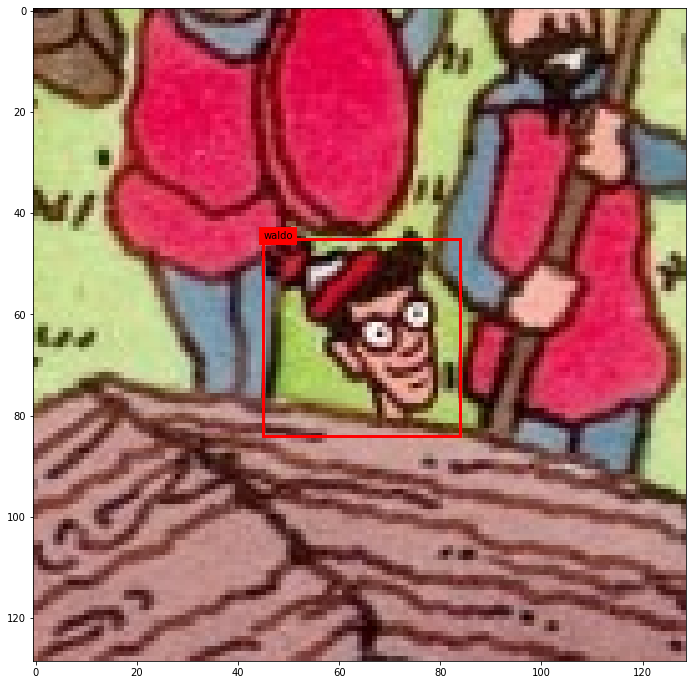

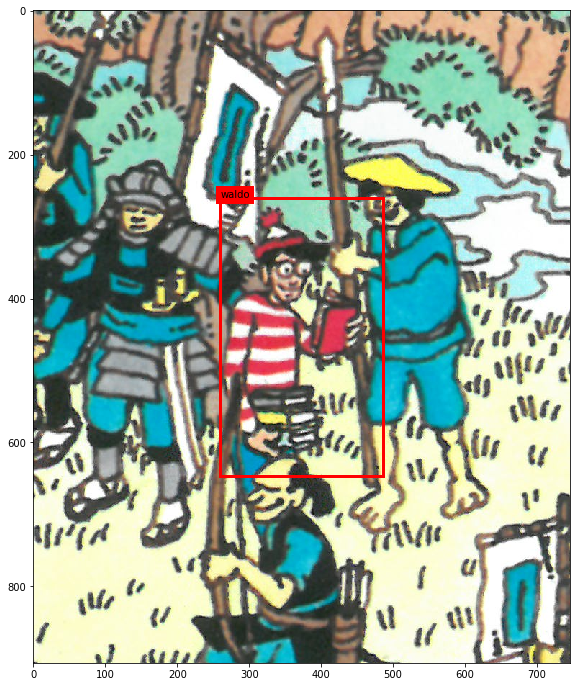

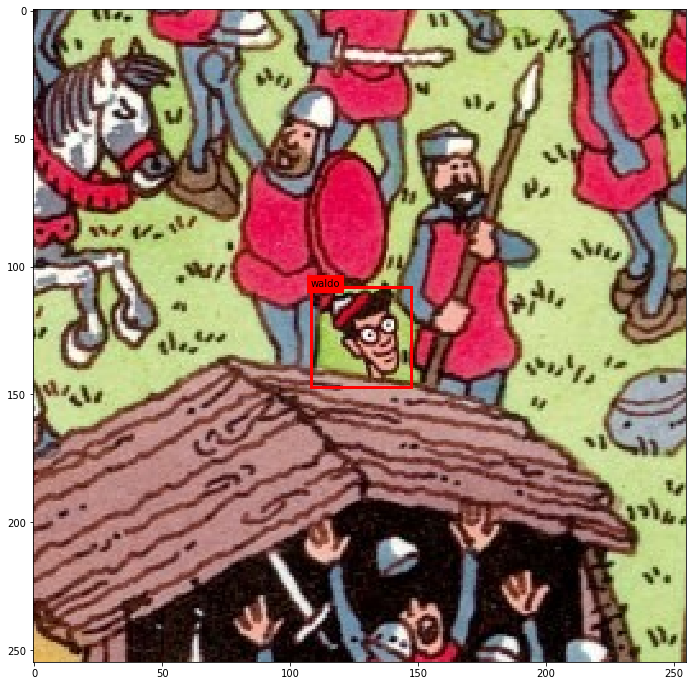

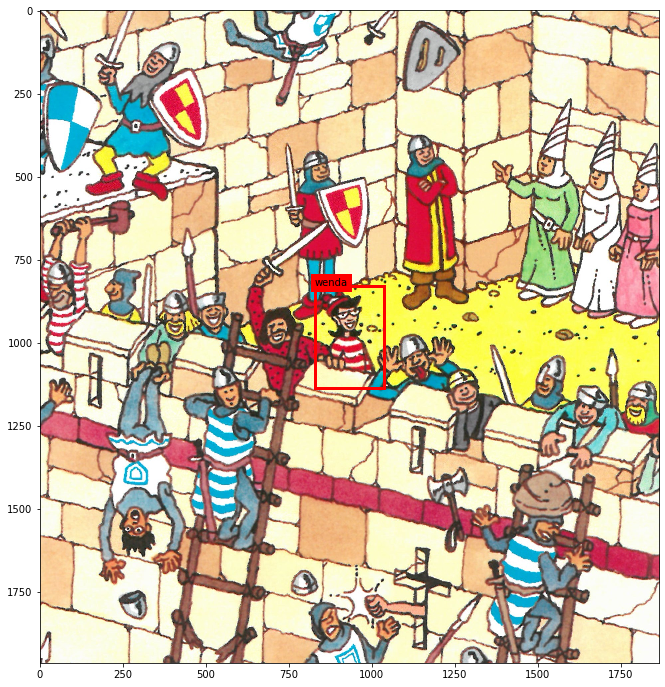

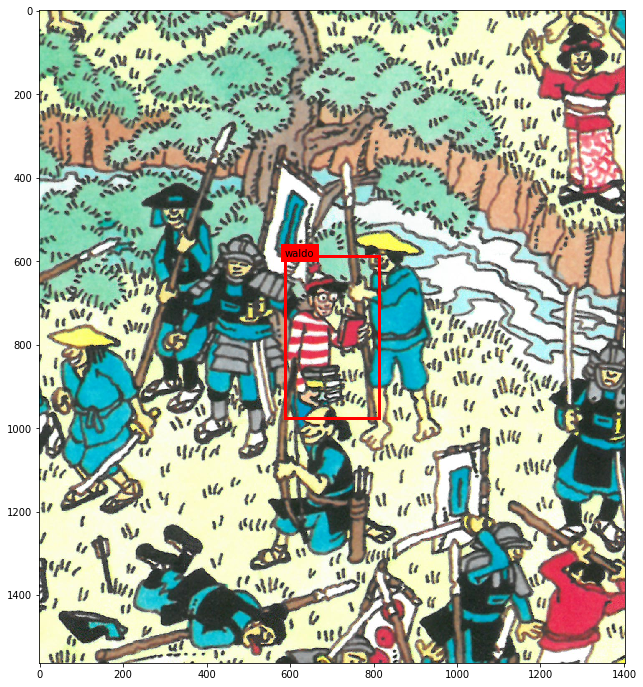

In [13]:
from vis_anno import draw_bbox2
from vis_anno import draw_annotation

samples = training_samples

print('num training samples: {}'.format(len(training_samples)))
print('num positive training samples: {}'.format(len(pos_training_samples)))

"""
for sample in np.random.choice(samples, 5, replace=False):
    fig, ax = plt.subplots(1)
    ax.imshow(sample['img'])
    print(sample['classes'])
    draw_annotation(ax, sample['classes'])
    plt.show()
"""

for idx, sample in enumerate(np.random.choice(pos_training_samples, 5, replace=False)):
    fig, ax = plt.subplots(1)
    plt.imshow(sample['img'])
    draw_bbox2(ax, sample['name'], sample['bbox'])
    plt.show()

In [14]:
import face_detect_haar.find_faces_using_cascades

# Get faces from all images
faces = []
print("Starting to search the images for faces...")
for i, img in enumerate(images):
    if i != 0:
        print("...still running...")
    img_faces = find_faces_using_cascades(img)
    faces.append(img_faces)
    print("Found {} faces in image {}!".format(len(img_faces), image_paths[i]))

ModuleNotFoundError: No module named 'face_detect_haar.find_faces_using_cascades'; 'face_detect_haar' is not a package

In [ ]:
# Generate annotated version of images with rectangles drawn around detected faces

images_anno = []
for i, img in enumerate(images):
    img_anno = images[i]
    for (x, y, w, h) in faces[i]:
        cv2.rectangle(img_anno, (x, y), (x + w, y + h), (255, 170, 0), 10)
    images_anno.append(img_anno)

In [ ]:
# Plot original and annotated images and save annotated images to disk

for i in range(n_images):
    
    rgb_img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.subplot(2*n_images+1, 1, i*2+1)
    plt.imshow(rgb_img)
    
    rgb_img_anno = cv2.cvtColor(images_anno[i], cv2.COLOR_BGR2RGB)
    plt.subplot(2*n_images+1, 1, i*2+2)
    plt.imshow(rgb_img_anno)
    
    plt.show()
    
    cv2.imwrite("anno_" + image_paths[i], images_anno[i])